# MNIST Image Classification with PyTorch

> ⚡ In this Project we are going to take the MNIST dataset and build a PyTorch model to classify the images of all the numbers

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.9 MB/s eta 0:00:00


In [2]:
# import all necessary dependencies
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets # Getting MNIST data from list of datasets
from torchvision.transforms import ToTensor # transforming images to tensor

import torchmetrics # evaluating with different metrics
import mlxtend # confusion matrix construction

import numpy as np
import matplotlib.pyplot as plt

## Load Data
* We are going to use `torchvision.datasets.MNIST` through which we will be able to get the training and testing data!
* Applying `torchvision.transforms.ToTensor()` which will convert all the images into tensors, for our model to process them faster

In [3]:
train_data = datasets.MNIST(
  root='data',
  train=True,
  download=True,
  transform=ToTensor()
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 124937528.53it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 15362802.01it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39886103.64it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13482327.51it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### View single image for each class in data

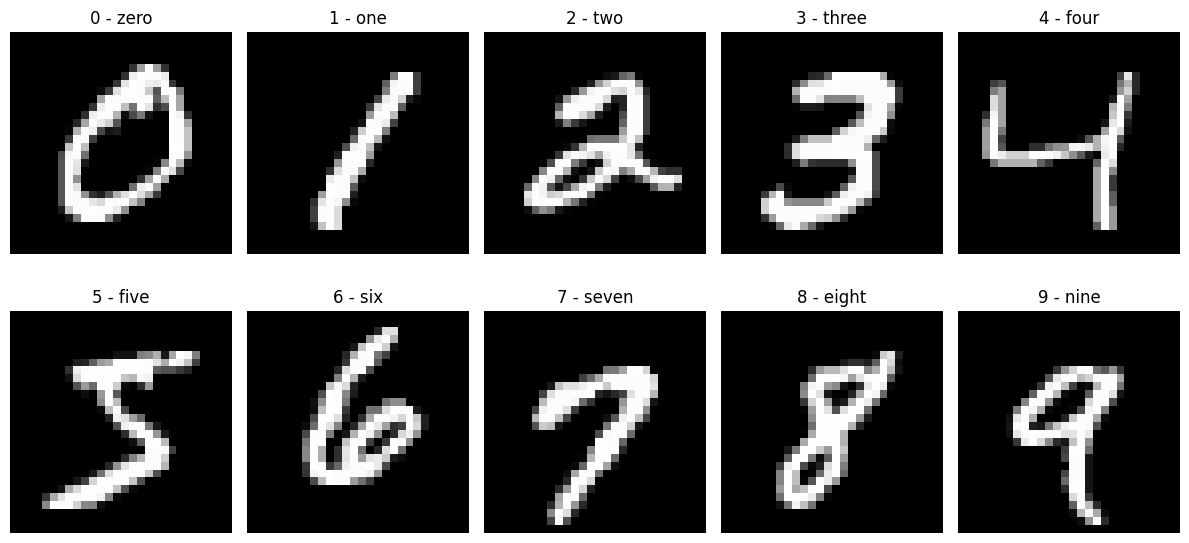

In [6]:
# Initialize variables to store indices of each class
class_indices = {key: [] for key in range(10)}

for idx, (img, label) in enumerate(train_data):
    class_indices[label].append(idx)

# Set up a subplot with 10 images (1 for each class)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

for i in range(10):
    class_img_index = class_indices[i][0]  # Take the first image for each class
    img, label = train_data[class_img_index]

    # Plot the image
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Batching our Data

Converting our data into Data Loaders is a very crucial step, as it batchifies our data into mini-batches of size 32 (in this case), which will be easier for our model to process!

In [7]:
train_dataloader = DataLoader(
    train_data, # Train data is used
    batch_size=32, # convert them into mini-batches of size 32
    shuffle=True, # Shuffle all our images
)

test_dataloader = DataLoader(
    test_data, # Test data is used
    batch_size=32, # convert them into mini-batches of 32
    shuffle=False # We do not want to shuffle images in test data
)

train_dataloader,  test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cd5142bfa90>,
 <torch.utils.data.dataloader.DataLoader at 0x7cd5142bef50>)

In [8]:
print(f'Train Data has {len(train_dataloader)} batches of size {train_dataloader.batch_size}')
print(f'Test Data has {len(test_dataloader)} batches of size {test_dataloader.batch_size}')

Train Data has 1875 batches of size 32
Test Data has 313 batches of size 32


In [9]:
images, labels = next(iter(train_dataloader))
images.shape, labels

(torch.Size([32, 1, 28, 28]),
 tensor([7, 3, 6, 3, 9, 3, 1, 3, 7, 3, 1, 8, 0, 0, 5, 9, 6, 0, 8, 1, 3, 1, 7, 7,
         0, 1, 8, 2, 7, 2, 9, 0]))

### Visualizing Random images from our dataset

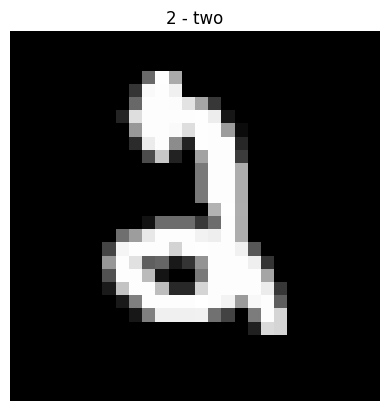

In [10]:
import random
random_idx = random.randint(0, train_dataloader.batch_size)
plt.imshow(images[random_idx].squeeze(), cmap='gray')
plt.title(class_names[labels[random_idx]])
plt.axis('off')
plt.show();

## Constructing our model

In [11]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
# Building PyTorch Model
class MNISTModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create Convolutional Layers along with Linear layers
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*7*7, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=10)
    )

  def forward(self, X:torch.tensor) -> torch.tensor:
    X = self.conv_block(X)
    # print(f'Shape of X (after conv_base): {X.shape}')
    X = self.classifier(X)
    return X


model = MNISTModelV0().to(device)
model

MNISTModelV0(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [13]:
next(model.parameters()).device

device(type='cuda', index=0)

In [14]:
# Making Predictions (to find the in_features after Flatten layer)
model.eval()
with torch.inference_mode():
  logits = model(images[0].unsqueeze(dim=0).to(device))
preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
preds

tensor([5], device='cuda:0')

### Setting up Loss Function and Optimizer for our PyTorch model

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)

In [16]:
def accuracy_fn(y_true, y_preds):
  correct = torch.eq(y_true, y_preds).sum().item()
  acc = correct/len(y_true) * 100
  return acc

### Create a function to time our experiments

Machine Learning is very experimental,

Two of the main things you'll often want to trach are:

1. Model's performance (loss and accuracy values)
2. How fast it runs

Model's Performance and the speed it runs, is usually a trade-off, the bigger the model, more better the performance, but  speed of the model in making predictions decreases!!


In [17]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints differences between start and end time."""
  total_time = end-start
  print(f'Train Time on {device}: {total_time:.3f} secs')
  return total_time

In [18]:
start_time = timer()
## some code here
end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')

Train Time on cpu: 0.000 secs


4.903899998964789e-05

## Training our model

In [19]:
EPOCHS = 10

train_time_start = timer()

for epoch in range(EPOCHS):
  print(f'Epoch: {epoch} \n---------------------')

  # Initializing our train loss and acc values for accumulation during training
  train_loss, train_acc = 0, 0

  # Put model to train mode
  model.train()

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    # Forward Propagation
    y_logits = model(X)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # calculate and append the loss and acc values
    loss = loss_fn(y_logits, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_preds)

    # Zero grad: clears all the graident computations made in the previous epoch
    optimizer.zero_grad()
    # Backpropagation
    loss.backward()
    # Gradient Descent
    optimizer.step()

    # Print out status of epoch every 400 batches
    if batch % 400 == 0:
      print(f'Processed Images: [{batch*train_dataloader.batch_size} / {len(train_dataloader)*train_dataloader.batch_size}]')

  # Calculate the average train loss and acc
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # Put model to evaluation model
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_logits = model(X)
      test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y, test_preds)

    # Calculate the average test loss and acc
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f'Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}')



train_time_end = timer()
total_train_time = print_train_time(start=train_time_start, end=train_time_end, device=device)
print(f'Total Training Time: {total_train_time} secs')

Epoch: 0 
---------------------
Processed Images: [0 / 60000]
Processed Images: [12800 / 60000]
Processed Images: [25600 / 60000]
Processed Images: [38400 / 60000]
Processed Images: [51200 / 60000]
Train Loss: 0.16851 | Train Accuracy: 94.74 | Test Loss: 0.05641 | Test Accuracy: 98.22
Epoch: 1 
---------------------
Processed Images: [0 / 60000]
Processed Images: [12800 / 60000]
Processed Images: [25600 / 60000]
Processed Images: [38400 / 60000]
Processed Images: [51200 / 60000]
Train Loss: 0.05193 | Train Accuracy: 98.41 | Test Loss: 0.04218 | Test Accuracy: 98.69
Epoch: 2 
---------------------
Processed Images: [0 / 60000]
Processed Images: [12800 / 60000]
Processed Images: [25600 / 60000]
Processed Images: [38400 / 60000]
Processed Images: [51200 / 60000]
Train Loss: 0.03601 | Train Accuracy: 98.90 | Test Loss: 0.04262 | Test Accuracy: 98.68
Epoch: 3 
---------------------
Processed Images: [0 / 60000]
Processed Images: [12800 / 60000]
Processed Images: [25600 / 60000]
Processed Im

## Evaluating our Model

* Evaluating in many metrics (using `torchmetrics`)
* Random Image plotting and Predictions
* Confusion Matrix (`torchmetrics`, `mlxtend`)

In [26]:
# Making Predictions
predictions = []
model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_preds = list(torch.argmax(torch.softmax(model(X), dim=1), dim=1).squeeze().cpu().numpy())
    predictions.extend(y_preds)
predictions = torch.tensor(predictions)

In [31]:
torch.stack([predictions, test_data.targets])

tensor([[7, 2, 1,  ..., 4, 5, 6],
        [7, 2, 1,  ..., 4, 5, 6]])

In [35]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

def torch_metrics(preds, target):

  torchmetric_acc = Accuracy(task="multiclass", num_classes=10)
  acc = torchmetric_acc(preds, target)

  torchmetric_precision = Precision(task="multiclass", num_classes=10, average='macro')
  precision = torchmetric_precision(preds, target)

  torchmetric_recall = Recall(task="multiclass", num_classes=10, average='macro')
  recall = torchmetric_recall(preds, target)

  torchmetric_f1 = F1Score(task="multiclass", num_classes=10, average='macro')
  f1 = torchmetric_f1(preds, target)

  return acc, precision, recall, f1

acc, prec, recall, f1_score = torch_metrics(preds=predictions, target=test_data.targets)
print(f'Accuracy: {acc*100}% \nPrecision: {prec*100}% \nRecall: {recall*100}% \nF1 Score: {f1_score*100}%')

Accuracy: 99.13999938964844% 
Precision: 99.14466094970703% 
Recall: 99.13998413085938% 
F1 Score: 99.14020538330078%


### Plotting random predictions with images

In [41]:
def generate_random_nums(lower_bound=0, upper_bound=10000):
  # Generate a list of 100 random numbers
  random_numbers = []
  for i in range(9):
      random_number = random.randint(lower_bound, upper_bound)
      random_numbers.append(random_number)

  return random_numbers

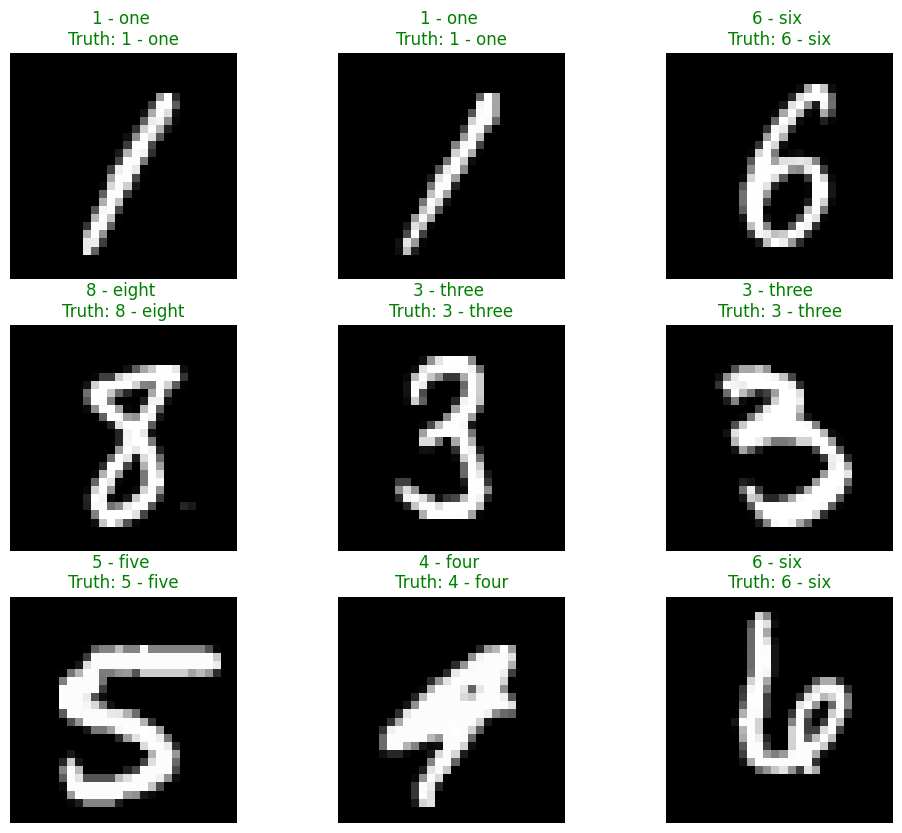

In [47]:
plt.figure(figsize=(12, 10))

nrows = 3
ncols=3
random_idx = generate_random_nums()

for i, num in enumerate(random_idx):
  plt.subplot(nrows, ncols, i+1)

  truth_label = test_data.targets[num].item()
  pred_label = predictions[num].item()
  img = test_data[num][0]

  plt.imshow(img.squeeze(), cmap='gray')
  plt.axis('off')

  title = f'{class_names[pred_label]} \nTruth: {class_names[truth_label]}'

  if pred_label == truth_label:
    plt.title(title, c='g')
  else:
    plt.title(title, c='r')

### Confusion Matrix

In [48]:
from torchmetrics import ConfusionMatrix
confmat = ConfusionMatrix(task="multiclass", num_classes=10)
matrix = confmat(predictions, test_data.targets)
matrix

tensor([[ 978,    0,    0,    0,    0,    0,    0,    1,    0,    1],
        [   0, 1125,    0,    0,    0,    0,    2,    8,    0,    0],
        [   1,    0, 1022,    0,    0,    0,    0,    9,    0,    0],
        [   0,    0,    2, 1005,    0,    1,    0,    1,    1,    0],
        [   0,    0,    1,    0,  970,    0,    1,    2,    0,    8],
        [   0,    0,    0,    2,    0,  887,    1,    1,    1,    0],
        [   1,    2,    1,    0,    2,    3,  946,    0,    3,    0],
        [   0,    1,    1,    0,    0,    0,    0, 1026,    0,    0],
        [   4,    1,    2,    1,    0,    0,    0,    3,  961,    2],
        [   0,    0,    1,    0,    3,    5,    0,    3,    3,  994]])

<Figure size 1200x600 with 0 Axes>

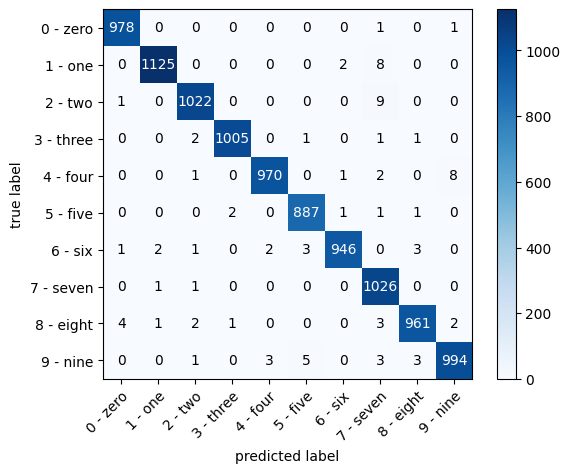

In [54]:
from mlxtend.plotting import plot_confusion_matrix

plt.figure(figsize=(12, 6))
fig, ax = plot_confusion_matrix(conf_mat=matrix.numpy(),
                                class_names=class_names,
                                colorbar=True
                                )
plt.show()

## Saving and re-loading our model

In [55]:
# saving our model's state_dict
torch.save(model.state_dict(), 'mnist_pytorch_model.pt')

In [57]:
loaded_model = MNISTModelV0().to(device)
loaded_model.load_state_dict(torch.load('mnist_pytorch_model.pt'))

<All keys matched successfully>

In [58]:
# Making Predictions
loaded_predictions = []
model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_preds = list(torch.argmax(torch.softmax(loaded_model(X), dim=1), dim=1).squeeze().cpu().numpy())
    loaded_predictions.extend(y_preds)
loaded_predictions = torch.tensor(loaded_predictions)

acc, prec, recall, f1_score = torch_metrics(preds=loaded_predictions, target=test_data.targets)
print(f'Accuracy: {acc*100}% \nPrecision: {prec*100}% \nRecall: {recall*100}% \nF1 Score: {f1_score*100}%')

Accuracy: 99.13999938964844% 
Precision: 99.14466094970703% 
Recall: 99.13998413085938% 
F1 Score: 99.14020538330078%
